In [1]:
from typing import Dict, Any

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.ripper import make_ripper_node
from architecture.utils import describe_architecture

In [2]:
dataset_df = pd.read_csv("./data/10_bit_artificial/107.csv")
X_df = dataset_df.drop(columns="class").to_numpy(bool)
y_df = dataset_df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

print("Small dataset shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Small dataset shapes:
X_train: (819, 10), X_test: (205, 10)
y_train: (819,), y_test: (205,)


In [3]:
config = dict(
    layer_node_counts=[8]*3 + [1],      # what if there are more than in the input
    layer_bit_counts=[4]*4,
    seed=42
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node, jobs=8)
%time net.fit(X_train, y_train)
pred_test = net.predict(X_test)
acc_test = accuracy_score(y_test, pred_test)
print(f"Accuracy on test set: {acc_test:.6f}")

CPU times: user 47.4 ms, sys: 119 ms, total: 166 ms
Wall time: 4.71 s
Accuracy on test set: 0.848780


In [4]:
def print_architecture(desc: Dict[str, Any]) -> None:
    first_backlinks = [b for n in desc["layers"][1]["nodes"] for b in n["backlinks"]]
    used_inputs = sorted(set(first_backlinks))

    print("Used Inputs:", ", ".join(used_inputs))
    print("Layers & backlinks:")
    for layer in desc["layers"][1:]:  # skip input layer
        print(f"  {layer['name']}: {len(layer['nodes'])} node(s)")
        for n in layer["nodes"]:
            print(f"    {n['name']} - {n['backlinks']}")


desc = describe_architecture(net)
desc
#print_architecture(desc)

{'layers': [{'name': 'INPUT',
   'nodes': [{'name': 'L0N0'},
    {'name': 'L0N1'},
    {'name': 'L0N2'},
    {'name': 'L0N3'},
    {'name': 'L0N4'},
    {'name': 'L0N5'},
    {'name': 'L0N6'},
    {'name': 'L0N7'},
    {'name': 'L0N8'},
    {'name': 'L0N9'}]},
  {'name': 'L1',
   'nodes': [{'name': 'L1N0',
     'backlinks': ['L0N1', 'L0N9'],
     'metadata': {'type': 'ripper',
      'seed': 383329927,
      'expression': 'L0N9 & ~L0N1'}},
    {'name': 'L1N1',
     'backlinks': ['L0N1', 'L0N4', 'L0N5', 'L0N8'],
     'metadata': {'type': 'ripper',
      'seed': 3324115916,
      'expression': '~L0N1 | ~L0N8 | (~L0N1 & ~L0N4) | (L0N5 & ~L0N1 & ~L0N8) | (~L0N1 & ~L0N4 & ~L0N5) | (~L0N1 & ~L0N4 & ~L0N8) | (~L0N1 & ~L0N5 & ~L0N8)'}},
    {'name': 'L1N2',
     'backlinks': ['L0N1', 'L0N6', 'L0N7', 'L0N8'],
     'metadata': {'type': 'ripper',
      'seed': 2811363264,
      'expression': '(L0N6 & ~L0N8) | (L0N6 & ~L0N1 & ~L0N8) | (L0N6 & ~L0N7 & ~L0N8) | (L0N7 & ~L0N1 & ~L0N8) | (L0N6 & L0N7 &

In [13]:
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.family": "DejaVu Sans",
    "font.weight": "bold"
})

def format_subscripts(name: str) -> str:
    """Format digits in names as subscripts (e.g. L2N7 -> $N_{7}$)."""
    return "$" + re.sub(r"([A-Za-z]+)(\d+)", r"\1_{\2}", name) + "$"

def plot_architecture_networkx(
        desc,
        *,
        layer_separation: float = 3.2,
        node_separation: float = 1.35,
        node_font_size: float = 12.0,
        header_font_size: float = 14.0,
        edge_width: float = 1.6,
        dpi: int = 120
):
    layers = desc["layers"]

    graph = nx.DiGraph()
    node_positions, node_labels = {}, {}
    for layer_idx, layer in enumerate(layers):
        node_names = [node["name"] for node in layer["nodes"]]
        num_nodes = len(node_names)

        node_y_positions = (np.arange(num_nodes)[::-1] - (num_nodes - 1) / 2.0) * node_separation
        node_x_positions = np.full(num_nodes, layer_idx * layer_separation)

        for node_idx, node_name in enumerate(node_names):
            node_positions[node_name] = (node_x_positions[node_idx], node_y_positions[node_idx])

            node_label = "N" + node_name.split("N", 1)[1]
            node_labels[node_name] = format_subscripts(node_label)

            for node_backlinks in layer["nodes"][node_idx].get("backlinks", []):
                if node_backlinks in node_positions:
                    graph.add_edge(node_backlinks, node_name)

    graph.add_nodes_from(node_positions)

    # layout and plot
    node_area = (node_font_size * 2.4) ** 2
    x_padding = 0.6 * layer_separation
    y_padding = 0.8 * node_separation
    header_offset = 0.6 * node_separation

    num_layers = max(1, len(layers))
    node_y_positions = [pos[1] for pos in node_positions.values()] or [0.0]
    node_y_min, node_y_max = min(node_y_positions), max(node_y_positions)
    node_x_min, node_x_max = -x_padding, (num_layers - 1) * layer_separation + x_padding
    node_y_min, node_y_max = node_y_min - y_padding, node_y_max + y_padding + header_offset

    figsize = ((node_x_max - node_x_min) * 0.90, (node_y_max - node_y_min) * 0.86)
    face_color = "white"
    draw_color = "black"

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_facecolor(face_color)

    nx.draw_networkx_edges(graph, node_positions, width=edge_width, edge_color=draw_color, arrows=False, ax=ax, alpha=0.95)
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_area, node_color=face_color, edgecolors=draw_color, linewidths=edge_width, ax=ax)
    nx.draw_networkx_labels(graph, node_positions, labels=node_labels, font_size=node_font_size, font_weight="bold", font_color=draw_color, ax=ax)

    ax.set_xlim(node_x_min, node_x_max)
    ax.set_ylim(node_y_min, node_y_max)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    # headers
    layer_titles = [format_subscripts(layer["name"]) for layer in layers]
    header_y_position = max(node_y_positions) + y_padding * 0.4 + header_offset

    for layer_idx, title in enumerate(layer_titles):
        header_x_position = layer_idx * layer_separation
        ax.text(header_x_position, header_y_position, title, ha="center", va="bottom", color=draw_color, fontweight="bold", fontsize=header_font_size)

    plt.show()

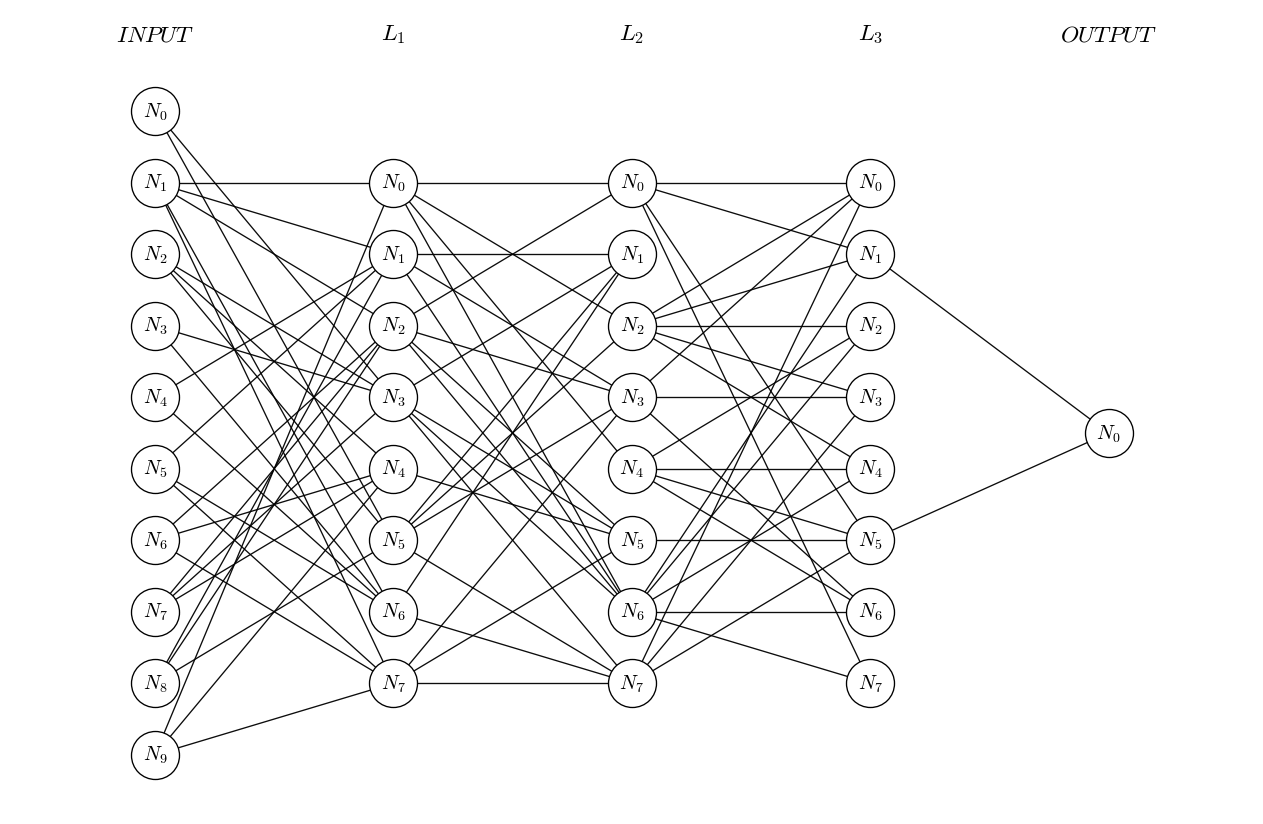

In [14]:
desc = describe_architecture(net)
plot_architecture_networkx(
    desc,
    layer_separation=3,
    node_separation=0.9,
    header_font_size = 14.0,
    edge_width=0.8,
)

In [15]:
def reduce_ripper_net(net) -> "DeepBinaryClassifier":
    for layer in net.layers:
        for node in layer:
            if hasattr(node, "reduce_expression"):
                node.reduce_expression()
    return net


red_net = reduce_ripper_net(net)
red_net.prune()

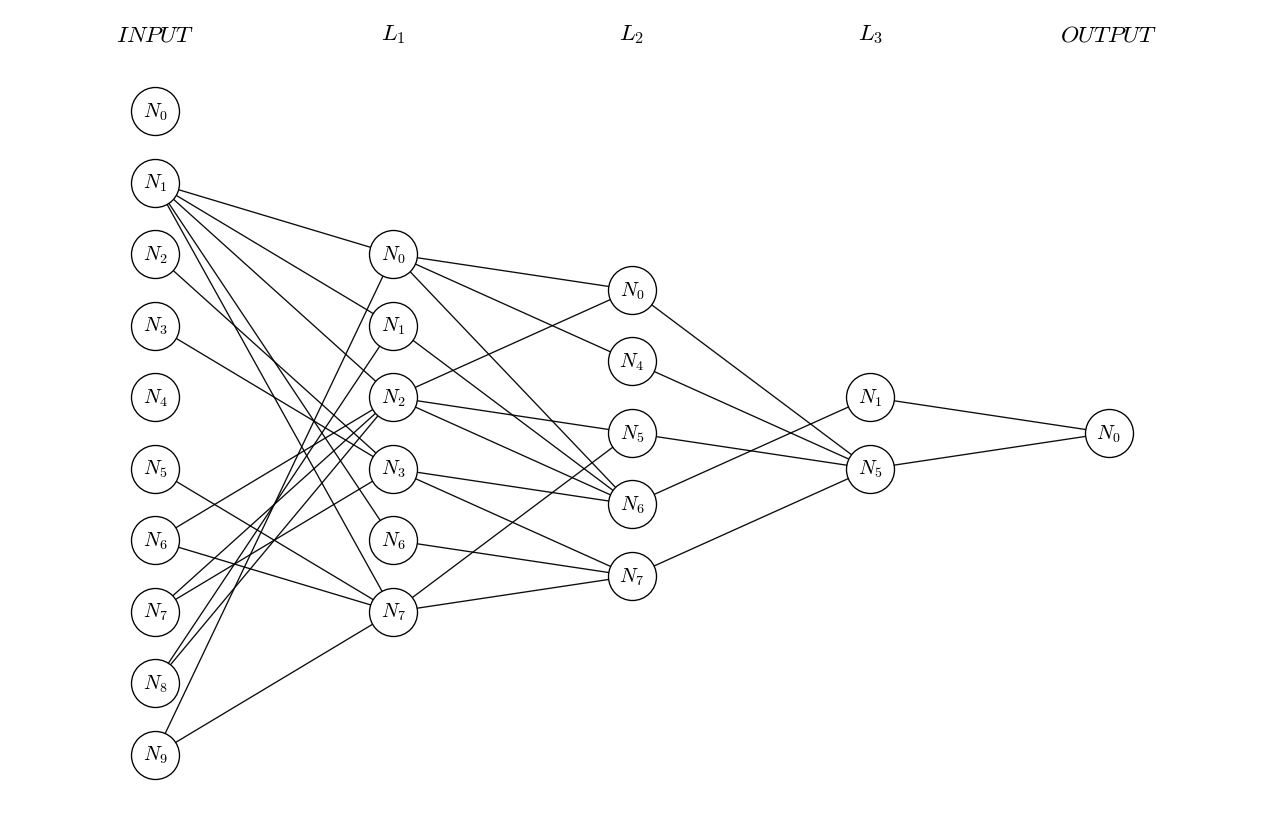

In [16]:
desc_after = describe_architecture(red_net)

plot_architecture_networkx(
    desc_after,
    layer_separation=3,
    node_separation=0.9,
    header_font_size = 14.0,
    edge_width=0.8,
)